<style>
  body { background-color: #121212; color: #ffffff; }
</style>

**<span style="color: gray;">In The Name of God</span>**

---


**<span style="color: #808080;">Mani hosseini</span>**<br>
**<span style="color: #808080;">SID:</span> <span style="color: #808080;">810102552</span>**<br>
**<span style="color: #808080;">Parsa Bukani</span>** <br>
**<span style="color: #808080;">SID:</span> <span style="color: #808080;">810102501</span>**<br>
**<span style="color: #808080;">Erfan Falahati</span>**<br>
**<span style="color: #808080;">SID:</span> <span style="color: #808080;">810102491</span>**


<div align="center">


# **Video Game Reviews**

</div>


## **<span style="color: #8A2BE2;">Preperation</span>**


### **<span style="color: #0D6EFD;">Importing modules</span>**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
from sklearn.random_projection import GaussianRandomProjection
from sklearn.manifold import MDS
from sklearn.manifold import LocallyLinearEmbedding
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder,StandardScaler,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegressionCV
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
from xgboost import XGBRegressor
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import roc_auc_score, roc_curve
import warnings
from sklearn.exceptions import UndefinedMetricWarning
from imblearn.over_sampling import SMOTE

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)



### **<span style="color: #0D6EFD;">Dataset Loading</span>**

In [2]:
def folder_join(file,folder1="content"):
    return os.path.join(folder1, file)




labeled_df=pd.read_csv(folder_join('labeled-data.csv'))
unlabeled_df=pd.read_csv(folder_join('unlabeled-data.csv'))
print("Unlabeled samples:")
print(unlabeled_df[:5])
print("\nLabeled samples:")
print(labeled_df[:5])

Unlabeled samples:
                                         review_text  review_score
0  While leaning heavily on traditional J-horror ...           NaN
1  Final Fantasy XIII-2 is a step in the right di...           NaN
2  Ultimately, this is the type of title that wil...           NaN
3  Super Monkey Ball Banana Mania combines 300 st...           NaN
4  I was hoping that Mario Party 5 would be bette...           NaN

Labeled samples:
                                         review_text  review_score
0  It&#146;s the best looking, most enticingly pu...             8
1  The Nintendo LABO Variety Kit has some fun and...             8
2  But as far as sound investments go, buying up ...             8
3  Starts out with a bang, but then quickly falls...             7
4  Valkyria Revolution tells a decent tale of war...             6



## **<span style="color: #8A2BE2;">Text Vectorization</span>**


### **<span style="color: #0D6EFD;">word2vecTransformer (Semantic Embeddings): </span>**

In [3]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
def feature_extractor(text):
    embeddings = model.encode(text,normalize_embeddings=True)
    return embeddings

unlabeled_df["review_sentence_embedded"]=unlabeled_df["review_text"].apply(feature_extractor)
labeled_df["review_sentence_embedded"]=labeled_df["review_text"].apply(feature_extractor)
np.save(folder_join("review_sentence_embedded_labeled.npy"),np.array(labeled_df["review_sentence_embedded"].tolist()))
np.save(folder_join("review_sentence_embedded_unlabeled.npy"),np.array(unlabeled_df["review_sentence_embedded"].tolist()))

### **<span style="color: #0D6EFD;">Word2Vec (Distributed Word Representations): </span>**

In [4]:


combined_df = pd.concat([labeled_df[['review_text',"review_score"]], unlabeled_df[['review_text',"review_score"]]], ignore_index=True)
tokenized_reviews = [text.split() for text in combined_df['review_text']]

model_w2v = Word2Vec(tokenized_reviews, vector_size=100, window=5, min_count=1,workers=4)


vocab = set(model_w2v.wv.index_to_key)

def average_word_vectors(words, model, vocab):
    feature_vector = np.zeros((model.vector_size,), dtype="float64")
    n_words = 0
    for word in words:
        if word in vocab:
            feature_vector += model.wv[word]
            n_words += 1
    if n_words > 0:
        feature_vector /= n_words
    return feature_vector

sentence_embeddings = np.array([
    average_word_vectors(tokens, model_w2v, vocab)
    for tokens in tokenized_reviews
])
np.save(folder_join("word2vec.npy"),sentence_embeddings)

load embeddings from file to avoid training

In [5]:
review_sentence_embedded_labeled=np.load(folder_join("review_sentence_embedded_labeled.npy"))
review_sentence_embedded_unlabeled=np.load(folder_join("review_sentence_embedded_unlabeled.npy"))
word2vec_embeddings=np.load(folder_join("word2vec.npy"))
# word2vec_embeddings = normalize(word2vec_embeddings, norm='l2')
# review_sentence_embedded_labeled=normalize(review_sentence_embedded_labeled,norm='l2')
# review_sentence_embedded_unlabeled=normalize(review_sentence_embedded_unlabeled,norm='l2')

### **<span style="color: #0D6EFD;">Dimensionality Reduction and Visualization:</span>**
Averaging word vectors has some problems:
- It ignores word order and syntax.
- It assumes all words contribute equally (e.g., "not good" ≠ "good").
- Subtle differences between sentiments can get blurred in the average

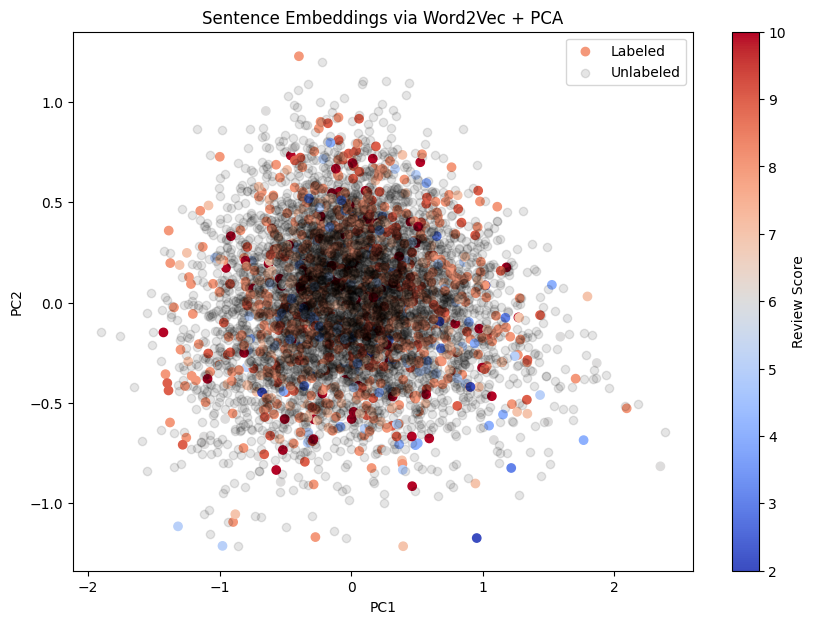

23.06% of variance was lost in 2D reduction.


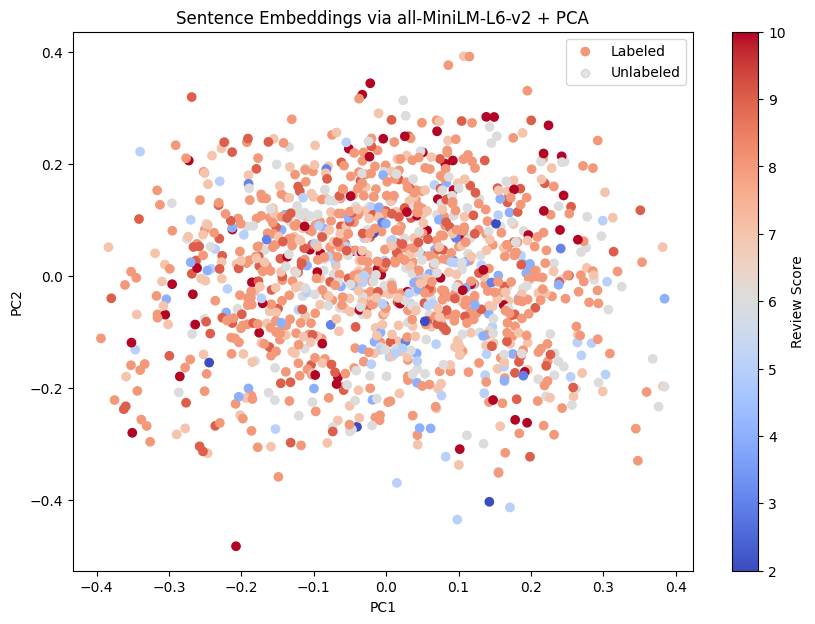

94.20% of variance was lost in 2D reduction.


In [6]:
def plot_pca(embeddings,type):
    two_d_pca = PCA(n_components=2)
    embeddings_2D = two_d_pca.fit_transform(embeddings)

    plt.figure(figsize=(10, 7))

    num_labeled = len(labeled_df)

    sc = plt.scatter(embeddings_2D[:num_labeled, 0],
                    embeddings_2D[:num_labeled, 1],
                    c=labeled_df['review_score'], cmap='coolwarm', label='Labeled')

    plt.scatter(embeddings_2D[num_labeled:, 0],
                embeddings_2D[num_labeled:, 1],
                c='black', alpha=0.1, label='Unlabeled')

    plt.colorbar(sc, label='Review Score')  
    plt.legend()
    plt.title(f"Sentence Embeddings via {type} + PCA")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

    print(f'{(1 - two_d_pca.explained_variance_ratio_.sum()) * 100:.2f}% of variance was lost in 2D reduction.')




plot_pca(word2vec_embeddings,type="Word2Vec")
plot_pca(review_sentence_embedded_labeled,type="all-MiniLM-L6-v2")

## **<span style="color: #8A2BE2;">**Supervised Learning Baselines**</span>**

### <span style="color: #0D6EFD;">**Classification Paradigm**:
</span>

In [7]:
num_labeled = len(labeled_df)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(
    word2vec_embeddings[:num_labeled ], labeled_df["review_score"], test_size=0.2, random_state=42, stratify=combined_df["review_score"][:num_labeled ]
)


X_train_mini, X_test_mini, y_train_mini, y_test_mini = train_test_split(
    review_sentence_embedded_labeled, labeled_df["review_score"], test_size=0.2, random_state=42, stratify=labeled_df["review_score"]
)



print(f"\nTrain size: {X_train_word2vec.shape}, Test size: {X_test_word2vec.shape}")
print("Class balance in train:", y_train_word2vec.value_counts())



smote = SMOTE(random_state=42,k_neighbors=4)


lr_model = Pipeline([
    ('scaler', StandardScaler()),
    # ('smote', smote),
    ('clf', LogisticRegressionCV(
        max_iter=500,
        # class_weight='balanced'
        ))
])

xgb_model = Pipeline([
    ('scaler', StandardScaler()),
    # ('smote', smote),
    ('clf', XGBClassifier(eval_metric='mlogloss'))
])

rf_model = Pipeline([
    ('scaler', StandardScaler()),
    # ('smote', smote),
    ('clf', RandomForestClassifier(
        n_estimators=200,
        max_depth=5,
        random_state=42,
        # class_weight='balanced'
    ))
])

models=[
        ('XGBoost', xgb_model),
        ('Random Forest',rf_model),
        ('Logistic Regression', lr_model),
        ]




def train_n_test(X_train,X_test,y_train,y_test,type):
    print(f"\nClassification Report using {type}")
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_test_enc = le.transform(y_test)
    for name, model in models:
        print(f"\n=== {name} ===")
        if name == "XGBoost":
            model.fit(X_train, y_train_enc)
            y_pred_enc = model.predict(X_test)
            y_pred = le.inverse_transform(y_pred_enc)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"Precision (macro): {precision_score(y_test, y_pred, average='macro'):.4f}")
        print(f"Recall (macro): {recall_score(y_test, y_pred, average='macro'):.4f}")
        print(f"F1 Score (macro): {f1_score(y_test, y_pred, average='macro'):.4f}")
        
        # print("Classification Report:")
        # print(classification_report(y_test, y_pred))
        
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))




Train size: (1000, 100), Test size: (250, 100)
Class balance in train: review_score
8     361
7     193
6     150
9     129
10     57
5      53
4      42
3      10
2       5
Name: count, dtype: int64



#### **<span style="color: #00FFFF;">all-MiniLM-L6-v2 embedding</span>**

In [8]:

train_n_test(X_train_mini,X_test_mini,y_train_mini,y_test_mini,type="all-MiniLM-L6-v2 embedding")


Classification Report using all-MiniLM-L6-v2 embedding

=== XGBoost ===
Accuracy: 0.3360
Precision (macro): 0.1597
Recall (macro): 0.1369
F1 Score (macro): 0.1287
Confusion Matrix:
[[ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  1  0  1]
 [ 0  0  0  0  3  0  7  0  0]
 [ 0  0  0  0  5  4  4  0  0]
 [ 0  0  0  0  4 11 22  1  0]
 [ 0  0  0  0  7  9 32  0  0]
 [ 0  0  0  0  4 11 67  8  1]
 [ 0  0  0  0  2  3 26  2  0]
 [ 0  0  0  0  0  2  8  2  2]]

=== Random Forest ===
Accuracy: 0.3640
Precision (macro): 0.0404
Recall (macro): 0.1111
F1 Score (macro): 0.0593
Confusion Matrix:
[[ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0 13  0  0]
 [ 0  0  0  0  0  0 38  0  0]
 [ 0  0  0  0  0  0 48  0  0]
 [ 0  0  0  0  0  0 91  0  0]
 [ 0  0  0  0  0  0 33  0  0]
 [ 0  0  0  0  0  0 14  0  0]]

=== Logistic Regression ===
Accuracy: 0.3640
Precision (macro): 0.0404
Recall (macro): 0.1111
F1 Score (macro): 0.0593
Confusion Matrix:
[[ 0  


#### **<span style="color: #00FFFF;">Word2Vec embedding</span>**

In [9]:

train_n_test(X_train_word2vec,X_test_word2vec,y_train_word2vec,y_test_word2vec,type="Word2Vec embedding")


Classification Report using Word2Vec embedding

=== XGBoost ===
Accuracy: 0.3280
Precision (macro): 0.1150
Recall (macro): 0.1270
F1 Score (macro): 0.1140
Confusion Matrix:
[[ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  1  1  0  0]
 [ 0  0  0  1  1  3  4  1  0]
 [ 0  0  0  0  1  1 11  0  0]
 [ 0  0  1  1  5  7 23  1  0]
 [ 0  1  0  0  5  7 29  6  0]
 [ 0  0  0  0  4 15 65  5  2]
 [ 0  0  0  0  6  6 16  5  0]
 [ 0  0  0  0  1  1  9  3  0]]

=== Random Forest ===
Accuracy: 0.3560
Precision (macro): 0.0404
Recall (macro): 0.1087
F1 Score (macro): 0.0589
Confusion Matrix:
[[ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0 13  0  0]
 [ 0  0  0  0  0  0 38  0  0]
 [ 0  0  0  0  0  0 47  1  0]
 [ 0  0  0  0  0  0 89  2  0]
 [ 0  0  0  0  0  0 33  0  0]
 [ 0  0  0  0  0  0 12  2  0]]

=== Logistic Regression ===
Accuracy: 0.3600
Precision (macro): 0.1513
Recall (macro): 0.1116
F1 Score (macro): 0.0644
Confusion Matrix:
[[ 0  0  0  0 


### **<span style="color: #0D6EFD;">Regression Paradigm:</span>**

In [10]:

regressors = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
}

def train_and_test_regressors(X_train, X_test, y_train, y_test, model_type):
    print(f"\n=== Regression Report using {model_type} ===")
    for name, model in regressors.items():
        pipeline = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('regressor', model)
        ])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        # print(y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        print(f"\n{name} Performance:")
        print(f"RMSE: {rmse:.2f}")
        print(f"R² Score: {r2:.4f}")
        print(f"MAE : {mae:.4f}")





#### **<span style="color: #00FFFF;">all-MiniLM-L6-v2 embedding</span>**

In [11]:

train_and_test_regressors(X_train_mini, X_test_mini, y_train_mini, y_test_mini, model_type="MiniLM")


=== Regression Report using MiniLM ===

Linear Regression Performance:
RMSE: 1.61
R² Score: -0.1677
MAE : 1.2557

Random Forest Performance:
RMSE: 1.37
R² Score: 0.1544
MAE : 1.0635

XGBoost Performance:
RMSE: 1.34
R² Score: 0.1846
MAE : 1.0510



#### **<span style="color: #00FFFF;">Word2Vec embedding</span>**

In [12]:

train_and_test_regressors(X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec, model_type="Word2Vec")


=== Regression Report using Word2Vec ===

Linear Regression Performance:
RMSE: 1.46
R² Score: 0.0337
MAE : 1.1532

Random Forest Performance:
RMSE: 1.48
R² Score: 0.0096
MAE : 1.1445

XGBoost Performance:
RMSE: 1.51
R² Score: -0.0383
MAE : 1.1716



### **<span style="color: #0D6EFD;">Conclusion:</span>**:
- for both regression and classification xgboost with a MiniLM wins
- regression+MiniLM+XGBoost was chosen as the better model because:
   - The regression output gives some meaningful continuous signal (unlike classification where it’s almost always one class).
    -   You can threshold or round the regression output to derive pseudo-labels for classification (e.g., round to nearest class).
    -  It’s more flexible: you can even use soft targets (e.g., confidence-weighted rounding).


## **<span style="color: #8A2BE2;">Semi-Supervised Learning (SSL) Strategies</span>**

### **<span style="color: #0D6EFD;">Pseudo-Labeling</span>**

#### **<span style="color: #00FFFF;">Classifcation</span>**

In [13]:

def pseudo_label_selection_classification(probs, top_percent):
    confidences = np.max(probs, axis=1)
    num_to_add = max(1, int(top_percent * len(confidences)))
    top_idx = np.argsort(confidences)[-num_to_add:]
    pseudo_labels = np.argmax(probs[top_idx], axis=1)
    return top_idx, pseudo_labels


def run_ssl_classification(X_labeled, y_labeled, X_unlabeled, num_iterations=5, top_percent=0.1):
    history = {}

    X_train_orig, X_eval, y_train_orig, y_eval = train_test_split(
        X_labeled, y_labeled, test_size=0.2, random_state=42, stratify=y_labeled
    )

    le = LabelEncoder()
    y_train_orig = le.fit_transform(y_train_orig)
    y_eval = le.transform(y_eval)

    X_train_ssl = X_train_orig.copy()
    y_train_ssl = y_train_orig.copy()
    remaining_unlabeled = X_unlabeled.copy()

    for i in range(num_iterations + 1):
        print(f"\n=== Iteration {i} ===")

        model = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, eval_metric='logloss', random_state=42)
        model.fit(X_train_ssl, y_train_ssl)

        y_pred_eval = model.predict(X_eval)
        acc = accuracy_score(y_eval, y_pred_eval)
        f1 = f1_score(y_eval, y_pred_eval, average="weighted", zero_division=0)

        print(f"Eval Accuracy: {acc:.4f}")
        print(classification_report(y_eval, y_pred_eval, zero_division=0))

        # AUC
        if len(np.unique(y_eval)) == 2:
            y_probs = model.predict_proba(X_eval)[:, 1]
            auc = roc_auc_score(y_eval, y_probs)
        else:
            y_probs = model.predict_proba(X_eval)
            auc = roc_auc_score(y_eval, y_probs, multi_class='ovr')

    
        history[f"iter{i+1}"] = {
            "AUC": auc,
            "F1": f1,
            "accuracy_score": acc,
            "y_probs": y_probs,
            "y_true": y_eval
        }

        
        if len(remaining_unlabeled) == 0:
            print("No more unlabeled data.")
            break

        # select confident labels
        pseudo_probs = model.predict_proba(remaining_unlabeled)
        top_idx, pseudo_labels = pseudo_label_selection_classification(pseudo_probs, top_percent)

        new_X = remaining_unlabeled[top_idx]
        new_y = pseudo_labels
        print(new_y)

        X_train_ssl = np.vstack([X_train_ssl, new_X])
        y_train_ssl = np.concatenate([y_train_ssl, new_y])
        remaining_unlabeled = np.delete(remaining_unlabeled, top_idx, axis=0)
        print(f"Added {len(new_X)} pseudo-labeled examples. New train size: {len(X_train_ssl)}")

    print("\n=== Final Evaluation on Held-out Eval Set ===")
    final_preds = model.predict(X_eval)
    print(classification_report(y_eval, final_preds, zero_division=0))
    return history

pseudo_classification_history=run_ssl_classification(review_sentence_embedded_labeled, labeled_df["review_score"],review_sentence_embedded_unlabeled, num_iterations=10, top_percent=0.01)



=== Iteration 0 ===
Eval Accuracy: 0.3280
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         2
           2       1.00      0.10      0.18        10
           3       0.00      0.00      0.00        13
           4       0.19      0.11      0.14        38
           5       0.17      0.12      0.14        48
           6       0.38      0.76      0.51        91
           7       0.10      0.03      0.05        33
           8       0.50      0.07      0.12        14

    accuracy                           0.33       250
   macro avg       0.26      0.13      0.13       250
weighted avg       0.28      0.33      0.25       250

[6 6 6 6 6 6 6 6 6 6 6 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 8 6 6 6 6 6
 6 6 6 6 6 5 6 6 8 8 8 8 8]
Added 50 pseudo-labeled examples. New train size: 1050

=== Iteration 1 ===
Eval Accuracy: 0.3360
              precision    recall  f1-score   suppo

#### **<span style="color: #00FFFF;">Regression</span>**

In [14]:
def pseudo_label_selection_regression(preds, top_percent):
    confidences = np.abs(preds - np.mean(preds))
    num_to_add = max(1, int(top_percent * len(preds)))
    top_idx = np.argsort(confidences)[-num_to_add:]
    return top_idx, preds[top_idx]


def run_ssl_reg(X_labeled, y_labeled, X_unlabeled, num_iterations=5, top_percent=0.1):
    history = {}

    X_train_orig, X_eval, y_train_orig, y_eval = train_test_split(
        X_labeled, y_labeled, test_size=0.2, random_state=42
    )

    X_train_ssl = X_train_orig.copy()
    y_train_ssl = y_train_orig.copy()
    remaining_unlabeled = X_unlabeled.copy()

    for i in range(num_iterations + 1):
        print(f"\n=== Iteration {i} ===")
        model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
        model.fit(X_train_ssl, y_train_ssl)

        y_pred = model.predict(X_eval)
        rmse = np.sqrt(mean_squared_error(y_eval, y_pred))
        mae = mean_absolute_error(y_eval, y_pred)
        r2 = r2_score(y_eval, y_pred)

        print(f"Eval RMSE: {rmse:.3f} | MAE: {mae:.3f} | R²: {r2:.4f}")
        history[f"iter{i+1}"] = {"RMSE": rmse, "MAE": mae, "R2": r2}

        if len(remaining_unlabeled) == 0:
            print("No more unlabeled data.")
            break

        pseudo_preds = model.predict(remaining_unlabeled)
        top_idx, selected_preds = pseudo_label_selection_regression(pseudo_preds, top_percent)

        new_X = remaining_unlabeled[top_idx]
        new_y = selected_preds

        X_train_ssl = np.vstack([X_train_ssl, new_X])
        y_train_ssl = np.concatenate([y_train_ssl, new_y])
        remaining_unlabeled = np.delete(remaining_unlabeled, top_idx, axis=0)

        print(f"Added {len(new_X)} pseudo-labeled examples. New train size: {len(X_train_ssl)}")

    print("\n=== Done ===")
    return history




reg_pseudo_history = run_ssl_reg(
    review_sentence_embedded_labeled,
    labeled_df["review_score"],
    review_sentence_embedded_unlabeled,
    num_iterations=10,
    top_percent=0.1
)



=== Iteration 0 ===
Eval RMSE: 1.391 | MAE: 1.043 | R²: 0.2225
Added 500 pseudo-labeled examples. New train size: 1500

=== Iteration 1 ===
Eval RMSE: 1.380 | MAE: 1.068 | R²: 0.2349
Added 450 pseudo-labeled examples. New train size: 1950

=== Iteration 2 ===
Eval RMSE: 1.346 | MAE: 1.024 | R²: 0.2727
Added 405 pseudo-labeled examples. New train size: 2355

=== Iteration 3 ===
Eval RMSE: 1.346 | MAE: 1.029 | R²: 0.2719
Added 364 pseudo-labeled examples. New train size: 2719

=== Iteration 4 ===
Eval RMSE: 1.365 | MAE: 1.047 | R²: 0.2516
Added 328 pseudo-labeled examples. New train size: 3047

=== Iteration 5 ===
Eval RMSE: 1.357 | MAE: 1.040 | R²: 0.2602
Added 295 pseudo-labeled examples. New train size: 3342

=== Iteration 6 ===
Eval RMSE: 1.347 | MAE: 1.033 | R²: 0.2709
Added 265 pseudo-labeled examples. New train size: 3607

=== Iteration 7 ===
Eval RMSE: 1.353 | MAE: 1.029 | R²: 0.2648
Added 239 pseudo-labeled examples. New train size: 3846

=== Iteration 8 ===
Eval RMSE: 1.372 | 

### **<span style="color: #0D6EFD;">Active Learning</span>**

#### **<span style="color: #00FFFF;">Classifcation</span>**

In [15]:


LEAST_CONF = "least_confidence_sampling"
MARGIN_SAMPLING = "margin_sampling"
ENTROPY = "entropy-based"




def get_entropy(probs):
    return -np.sum(probs * np.log(probs + 1e-10), axis=1)

def get_margin(probs):
    part = np.partition(-probs, 1, axis=1)
    top1 = -part[:, 0]
    top2 = -part[:, 1]
    return top1 - top2



def label(top_idx, k, original_df,iter, mode=LEAST_CONF):
    save_file = folder_join(f"{mode}.csv")

    if os.path.exists(save_file):
        prev_labeled = pd.read_csv(save_file)
    else:
        prev_labeled = pd.DataFrame(columns=["review_text", "review_score"])

    if len(prev_labeled["review_score"])>iter * k:

        tokenized_reviews = [text.split() for text in prev_labeled["review_text"][iter*k:(iter+1)*k] ]

        new_embeddings=[average_word_vectors(words=words,model=model_w2v,vocab=vocab) for words in tokenized_reviews]
        return np.array(new_embeddings), np.array(prev_labeled["review_score"][iter*k:(iter+1)*k])
    else:
        new_samples = original_df.iloc[top_idx][["review_text"]].copy()
        new_labels = []

        for i, text in enumerate(new_samples["review_text"].values):
            print(f"\n[{i+1}/{k}] text: {text}")
            label = input("Enter the correct label: ")
            new_labels.append(label)

        new_samples["review_score"] = new_labels
        prev_labeled = pd.concat([prev_labeled, new_samples.rename(columns={"review_text": "review_text"})], ignore_index=True)


        prev_labeled.to_csv(save_file, index=False)

        tokenized_reviews = [text.split() for text in new_samples
                            ["review_text"]]
        new_embeddings=[average_word_vectors(words=words,model=model_w2v,vocab=vocab) for words in tokenized_reviews]
        return np.array(new_embeddings), new_labels





def active_learning(X_labeled, y_labeled, X_unlabeled, original_df, num_iterations=5, top_k=50, mode=LEAST_CONF):
    history = {}

    X_train_orig, X_eval, y_train_orig, y_eval = train_test_split(
        X_labeled, y_labeled, test_size=0.2, random_state=42, stratify=y_labeled
    )

    le = LabelEncoder()
    y_train_orig = le.fit_transform(y_train_orig)
    y_eval = le.transform(y_eval)

    X_train_ssl = X_train_orig.copy()
    y_train_ssl = y_train_orig.copy()
    remaining_unlabeled = X_unlabeled.copy()
    original_unlabeled_df = original_df.copy()

    for i in range(num_iterations):
        print(f"\n=== Iteration {i} ===")

        model = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1,
                              eval_metric='logloss', random_state=42)
        model.fit(X_train_ssl, y_train_ssl)

        y_pred_eval = model.predict(X_eval)
        acc = accuracy_score(y_eval, y_pred_eval)
        f1 = f1_score(y_eval, y_pred_eval, average="weighted", zero_division=0)

        if len(remaining_unlabeled) == 0:
            print("No more unlabeled data.")
            break

        pseudo_probs = model.predict_proba(remaining_unlabeled)

        if mode == LEAST_CONF:
            confidences = np.max(pseudo_probs, axis=1)
            top_idx = np.argsort(confidences)[:top_k]
        elif mode == MARGIN_SAMPLING:
            margins = get_margin(pseudo_probs)
            top_idx = np.argsort(margins)[:top_k]
        elif mode == ENTROPY:
            entropies = get_entropy(pseudo_probs)
            top_idx = np.argsort(entropies)[-top_k:]
        else:
            raise ValueError("Unknown mode")

        X_new, y_new = label(top_idx, top_k, original_unlabeled_df,i,mode)

        X_train_ssl = np.vstack([X_train_ssl, X_new])
        y_train_ssl = np.concatenate([y_train_ssl, le.transform(y_new)])
        remaining_unlabeled = np.delete(remaining_unlabeled, top_idx, axis=0)
        original_unlabeled_df = original_unlabeled_df.drop(original_unlabeled_df.index[top_idx])

        if len(np.unique(y_eval)) == 2:
            y_probs = model.predict_proba(X_eval)[:, 1]
            auc = roc_auc_score(y_eval, y_probs)
        else:
            y_probs = model.predict_proba(X_eval)
            auc = roc_auc_score(y_eval, y_probs, multi_class='ovr')

        

        print("AUC", auc.round(4))
        print("F1",f1.round(4))
        print("accuracy_score",acc)
        history[f"iter{i+1}"] = {
            "AUC": auc,
            "F1": f1,
            "accuracy_score": acc
        }

        print(f"Added {len(X_new)} manually-labeled examples. New train size: {len(X_train_ssl)}")

    print("\n=== Final Evaluation on Held-out Eval Set ===")
    final_preds = model.predict(X_eval)
    # print(classification_report(y_eval, final_preds, zero_division=0))
    print(confusion_matrix(y_eval, final_preds))
    print("AUC", auc.round(4))
    print("F1",f1.round(4))
    print("accuracy_score",acc)
    return history





margin_history= active_learning(
    X_labeled=word2vec_embeddings[:num_labeled],
    y_labeled=labeled_df["review_score"],
    X_unlabeled=word2vec_embeddings[num_labeled:],
    original_df=unlabeled_df,
    num_iterations=5,
    top_k=40,
    mode=MARGIN_SAMPLING
)









=== Iteration 0 ===
AUC 0.4681
F1 0.2498
accuracy_score 0.32
Added 40 manually-labeled examples. New train size: 1040

=== Iteration 1 ===
AUC 0.516
F1 0.2528
accuracy_score 0.312
Added 40 manually-labeled examples. New train size: 1080

=== Iteration 2 ===
AUC 0.4794
F1 0.2546
accuracy_score 0.316
Added 40 manually-labeled examples. New train size: 1120

=== Iteration 3 ===
AUC 0.5108
F1 0.2532
accuracy_score 0.312
Added 40 manually-labeled examples. New train size: 1160

=== Iteration 4 ===
AUC 0.5134
F1 0.2533
accuracy_score 0.312
Added 40 manually-labeled examples. New train size: 1200

=== Final Evaluation on Held-out Eval Set ===
[[ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  1  3  5  1  0]
 [ 0  0  0  0  0  1 12  0  0]
 [ 0  0  1  1  4 13 18  1  0]
 [ 0  0  1  0  7 10 25  5  0]
 [ 0  0  0  1  7 14 62  6  1]
 [ 0  0  0  1  5  3 22  2  0]
 [ 0  0  0  0  0  1 11  2  0]]
AUC 0.5134
F1 0.2533
accuracy_score 0.312


In [16]:





least_conf_history= active_learning(
    X_labeled=word2vec_embeddings[:num_labeled],
    y_labeled=labeled_df["review_score"],
    X_unlabeled=word2vec_embeddings[num_labeled:],
    original_df=unlabeled_df,
    num_iterations=5,
    top_k=40,
    mode=LEAST_CONF
)










=== Iteration 0 ===
AUC 0.4681
F1 0.2498
accuracy_score 0.32
Added 40 manually-labeled examples. New train size: 1040

=== Iteration 1 ===
AUC 0.4864
F1 0.2374
accuracy_score 0.296
Added 40 manually-labeled examples. New train size: 1080

=== Iteration 2 ===
AUC 0.5577
F1 0.2385
accuracy_score 0.308
Added 40 manually-labeled examples. New train size: 1120

=== Iteration 3 ===
AUC 0.6034
F1 0.2328
accuracy_score 0.292
Added 40 manually-labeled examples. New train size: 1160

=== Iteration 4 ===
AUC 0.5392
F1 0.2445
accuracy_score 0.316
Added 40 manually-labeled examples. New train size: 1200

=== Final Evaluation on Held-out Eval Set ===
[[ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  1  1  0  0]
 [ 0  0  0  0  1  3  5  1  0]
 [ 0  0  0  0  1  1 11  0  0]
 [ 0  0  0  0  4 10 24  0  0]
 [ 0  0  0  0  1  9 33  4  1]
 [ 0  0  0  0  5 14 65  7  0]
 [ 0  0  1  0  3  3 25  1  0]
 [ 0  0  0  1  0  0 11  2  0]]
AUC 0.5392
F1 0.2445
accuracy_score 0.316


#### **<span style="color: #00FFFF;">Regression</span>**

In [17]:
def active_learning_regression(X_labeled, y_labeled, X_unlabeled, original_df, num_iterations=5, top_k=50):
    history = {}

    X_train_orig, X_eval, y_train_orig, y_eval = train_test_split(
        X_labeled, y_labeled, test_size=0.2, random_state=42
    )

    X_train_ssl = X_train_orig.copy()
    y_train_ssl = y_train_orig.copy()
    remaining_unlabeled = X_unlabeled.copy()
    original_unlabeled_df = original_df.copy()

    for i in range(num_iterations):
        print(f"\n=== Iteration {i} ===")

        model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
        model.fit(X_train_ssl, y_train_ssl)

        y_pred_eval = model.predict(X_eval)
        rmse = np.sqrt(mean_squared_error(y_eval, y_pred_eval))
        r2 = r2_score(y_eval, y_pred_eval)
        mae = mean_absolute_error(y_eval, y_pred_eval)

        print(f"Eval RMSE: {rmse:.4f}")
        print(f"Eval R²: {r2:.4f}")

        if len(remaining_unlabeled) == 0:
            print("No more unlabeled data.")
            break

        preds_unlabeled = model.predict(remaining_unlabeled)

        uncertainty = np.abs(preds_unlabeled - np.mean(preds_unlabeled))

        top_idx = np.argsort(uncertainty)[-top_k:]
        new_X, new_y = label(top_idx, top_k, original_unlabeled_df,iter=i,mode=LEAST_CONF)

        X_train_ssl = np.vstack([X_train_ssl, new_X])
        y_train_ssl = np.concatenate([y_train_ssl, new_y])

        remaining_unlabeled = np.delete(remaining_unlabeled, top_idx, axis=0)
        original_unlabeled_df = original_unlabeled_df.drop(original_unlabeled_df.index[top_idx])

        history[f"iter{i+1}"] = {"RMSE": rmse, "MAE": mae, "R2": r2}

        print(f"Added {len(new_X)} manually-labeled examples. New train size: {len(X_train_ssl)}")

    print("\n=== Final Evaluation on Held-out Eval Set ===")
    final_preds = model.predict(X_eval)
    print(f"Final RMSE: {np.sqrt(mean_squared_error(y_eval, final_preds)):.4f}")
    print(f"Final R²: {r2_score(y_eval, final_preds):.4f}")

    return history





reg_history= active_learning_regression(
    X_labeled=word2vec_embeddings[:num_labeled],
    y_labeled=labeled_df["review_score"],
    X_unlabeled=word2vec_embeddings[num_labeled:],
    original_df=unlabeled_df,
    num_iterations=5,
    top_k=40
)



=== Iteration 0 ===
Eval RMSE: 1.5878
Eval R²: -0.0124
Added 40 manually-labeled examples. New train size: 1040

=== Iteration 1 ===
Eval RMSE: 1.5959
Eval R²: -0.0227
Added 40 manually-labeled examples. New train size: 1080

=== Iteration 2 ===
Eval RMSE: 1.5791
Eval R²: -0.0013
Added 40 manually-labeled examples. New train size: 1120

=== Iteration 3 ===
Eval RMSE: 1.5948
Eval R²: -0.0213
Added 40 manually-labeled examples. New train size: 1160

=== Iteration 4 ===
Eval RMSE: 1.5748
Eval R²: 0.0041
Added 40 manually-labeled examples. New train size: 1200

=== Final Evaluation on Held-out Eval Set ===
Final RMSE: 1.5748
Final R²: 0.0041


## **<span style="color: #8A2BE2;">Evaluation</span>**

### **<span style="color: #0D6EFD;">Pseudo-Labeling</span>**

#### **<span style="color: #00FFFF;">Classifcation</span>**

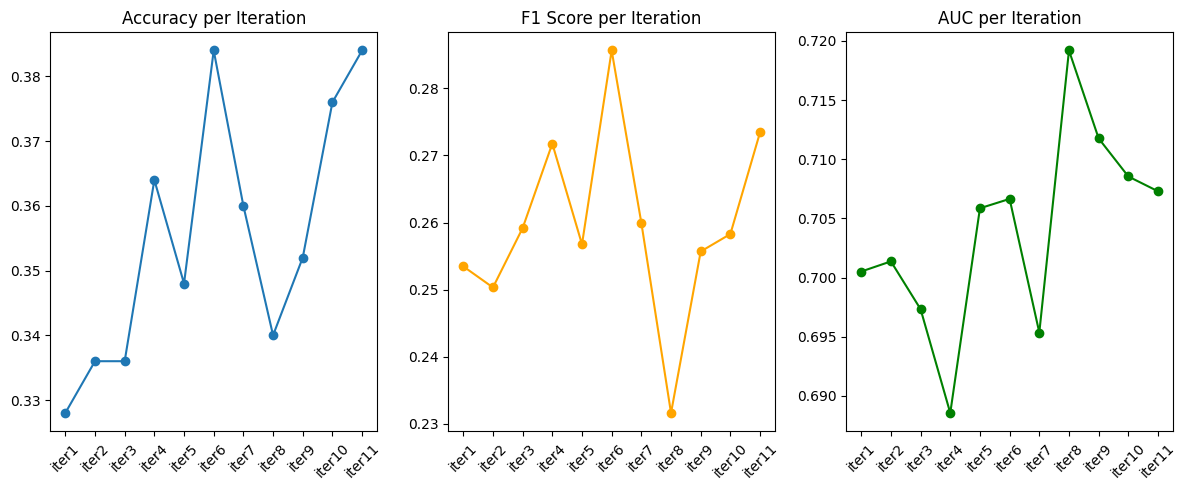

In [18]:


def plot_ssl_classfication_history(history):
    iters = list(history.keys())
    accs = [history[i]["accuracy_score"] for i in iters]
    f1s = [history[i]["F1"] for i in iters]
    aucs = [history[i]["AUC"] for i in iters]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 3, 1)
    plt.plot(iters, accs, marker='o')
    plt.title("Accuracy per Iteration")
    plt.xticks(rotation=45)

    plt.subplot(1, 3, 2)
    plt.plot(iters, f1s, marker='o', color='orange')
    plt.title("F1 Score per Iteration")
    plt.xticks(rotation=45)

    plt.subplot(1, 3, 3)
    plt.plot(iters, aucs, marker='o', color='green')
    plt.title("AUC per Iteration")
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()



plot_ssl_classfication_history(pseudo_classification_history)

#### **<span style="color: #00FFFF;">Regression</span>**

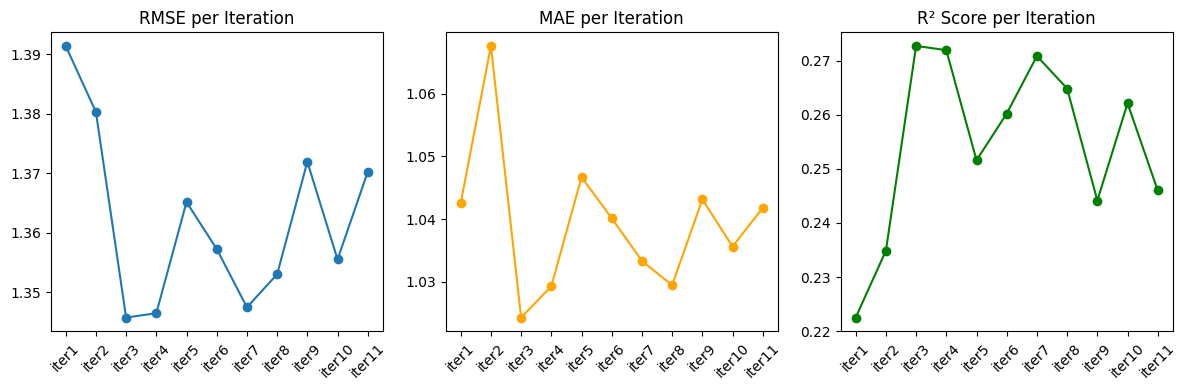

In [19]:
def plot_ssl_reg_history(history):
    iters = list(history.keys())
    rmse = [history[i]["RMSE"] for i in iters]
    mae = [history[i]["MAE"] for i in iters]
    r2 = [history[i]["R2"] for i in iters]

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(iters, rmse, marker='o')
    plt.title("RMSE per Iteration")
    plt.xticks(rotation=45)

    plt.subplot(1, 3, 2)
    plt.plot(iters, mae, marker='o', color='orange')
    plt.title("MAE per Iteration")
    plt.xticks(rotation=45)

    plt.subplot(1, 3, 3)
    plt.plot(iters, r2, marker='o', color='green')
    plt.title("R² Score per Iteration")
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

plot_ssl_reg_history(reg_pseudo_history)

### **<span style="color: #0D6EFD;">Active Learning</span>**

#### **<span style="color: #00FFFF;">Classifcation</span>**

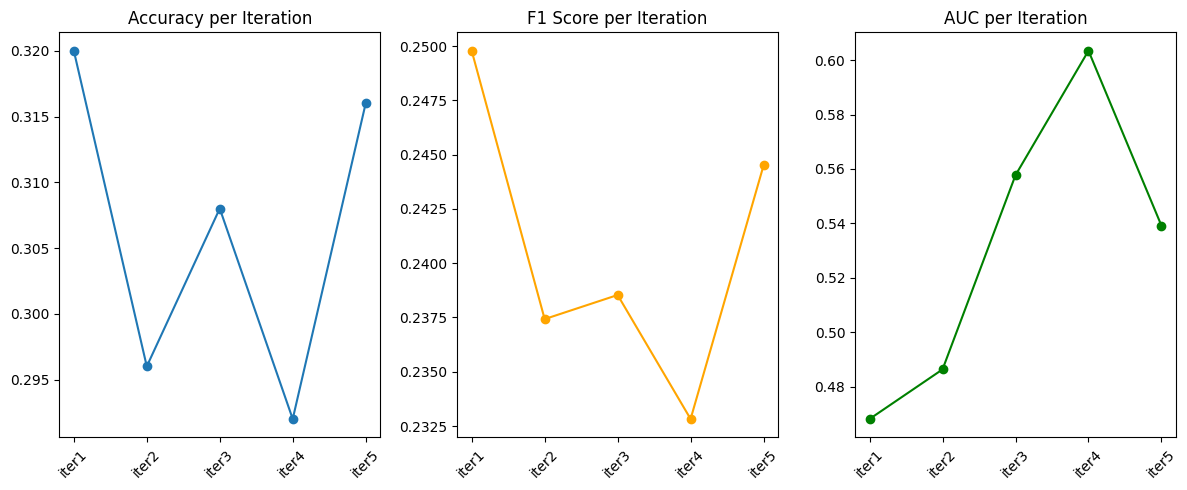

In [20]:
plot_ssl_classfication_history(least_conf_history)

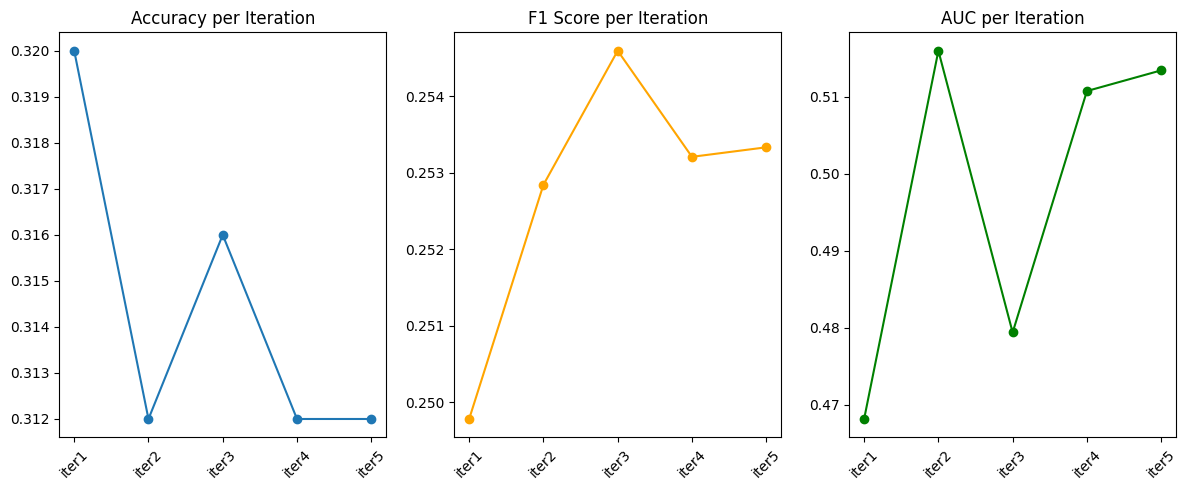

In [21]:
plot_ssl_classfication_history(margin_history)

#### **<span style="color: #00FFFF;">Regression</span>**

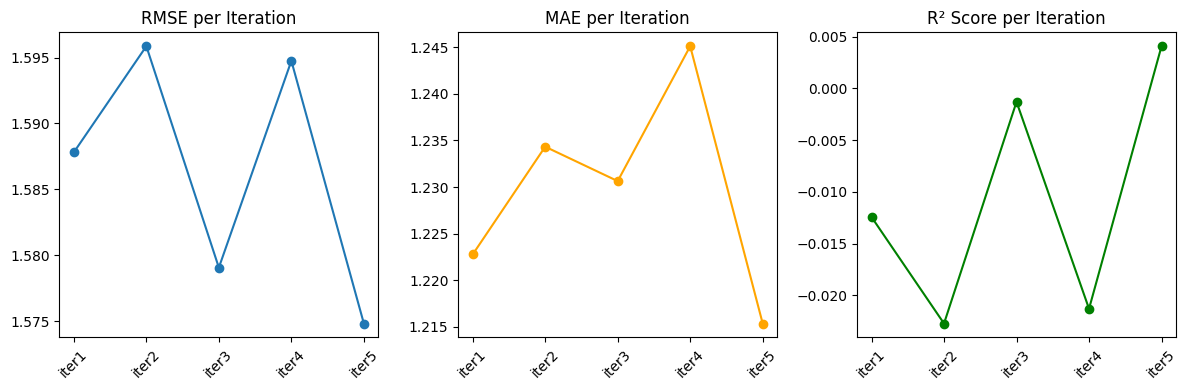

In [22]:

plot_ssl_reg_history(reg_history)

### **<span style="color: #0D6EFD;">Discussion</span>**

**Pseudo-Labeling**:

  * Gradually improves performance as more pseudo-labeled samples are added.
  * Works best when model confidence is high and predictions are close to the true labels.
* **Pros**:

  * No labeling cost.
  * Scales well with large unlabeled data.
* **Cons**:

  * **Confirmation Bias**: if the model is wrong, those wrong labels get reinforced.
  * **No error correction**: Once added, mistakes stay in the training set.

**Active Learning**:

  * More data-efficient: focuses labeling effort on the most uncertain or informative samples (via least confidence, margin, or entropy sampling).
  * Human-in-the-loop supervision ensures high-quality labeled additions.
  * Often outperforms pseudo-labeling when labeling budget is limited.
* **Pros**:

  * Selects the **most informative** or **uncertain** samples.
  * Allows **human validation**, reducing error accumulation.
* **Cons**:

  * Requires **human labeling** → time and effort cost.
  * Sampling strategies may not always pick the “most helpful” samples if feature space is poorly understood.


